## Thêm thư viện

In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from keras.utils import np_utils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras.callbacks import CSVLogger
from sklearn import metrics
from sklearn.metrics import confusion_matrix

## Đọc dữ liệu

In [31]:
file_url = "SMOTE_Borderline_Data.xlsx"
df1 = pd.read_excel(file_url)
df1 = df1.loc[:, ~df1.columns.str.contains('^Unnamed')]
df1.head()

,EE1,EE2,EE3,MI,IT,PH,ME,EE4_GPA
0,8.70,5.569444,6.879545,4.600000,6.25,6.150,5.45,3
1,7.65,5.783333,5.008333,3.283333,6.40,4.950,3.90,3
2,9.05,4.980000,5.865000,4.957895,6.20,5.450,5.80,3
3,8.65,7.970000,8.504545,8.531818,8.65,8.775,9.05,4
4,8.00,6.966667,7.052273,6.018182,7.00,6.675,4.25,3


## Lấy dữ liệu và nhãn

In [32]:
X = df1.drop("EE4_GPA", axis = 'columns')
y = df1["EE4_GPA"]

In [33]:
X = np.array(X)
y = np.array(y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [35]:
X_val = X_train[450:600, :] 
y_val = y_train[450:600]
X_train = X_train[0:450, :] 
y_train = y_train[0:450]

In [36]:
Y_train = np_utils.to_categorical(y_train, 5)
Y_test = np_utils.to_categorical(y_test, 5)
Y_val = np_utils.to_categorical(y_val, 5)

In [37]:
csv_logger = CSVLogger( 'cnn_model.log', separator=',', append=False )

## Huấn luyện mô hình

In [38]:
network = models.Sequential()
network.add(layers.Dense(32, activation='relu', input_shape=(7, )))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dense(16, activation='relu'))
network.add(layers.Dense(8, activation='relu'))
network.add(layers.Dense(5, activation='softmax'))
#
# Configure the network with optimizer, loss function and accuracy
#
network.compile(optimizer = "RMSProp",
                loss='categorical_crossentropy',
                metrics=['accuracy'])
#

# Fit the network
#
history = network.fit(np.array(X_train), Y_train,
                    validation_data = (X_val, Y_val),
                    epochs = 200,
                    batch_size = 20,
                    callbacks = [csv_logger])

Epoch 1/200
23/23 [==============================] - 1s 15ms/step - loss: 1.6116 - accuracy: 0.2311 - val_loss: 1.6099 - val_accuracy: 0.1867
Epoch 2/200
23/23 [==============================] - 0s 3ms/step - loss: 1.6129 - accuracy: 0.2133 - val_loss: 1.6120 - val_accuracy: 0.2200
Epoch 3/200
23/23 [==============================] - 0s 2ms/step - loss: 1.6104 - accuracy: 0.1933 - val_loss: 1.6094 - val_accuracy: 0.1933
Epoch 4/200
23/23 [==============================] - 0s 2ms/step - loss: 1.6094 - accuracy: 0.1844 - val_loss: 1.6100 - val_accuracy: 0.2200
Epoch 5/200
23/23 [==============================] - 0s 3ms/step - loss: 1.5978 - accuracy: 0.2356 - val_loss: 1.6175 - val_accuracy: 0.1800
Epoch 6/200
23/23 [==============================] - 0s 5ms/step - loss: 1.5841 - accuracy: 0.2422 - val_loss: 1.6734 - val_accuracy: 0.1800
Epoch 7/200
23/23 [==============================] - 0s 4ms/step - loss: 1.5868 - accuracy: 0.2289 - val_loss: 1.5747 - val_accuracy: 0.3067
Epoch 8/200


In [39]:
# Hàm lấy giá trị đầu ra
def get_one_hot_pred(y_pred, num_classes):
    y_pred_one_hot = np.argmax(y_pred, axis=-1)
    y_pred_one_hot = np_utils.to_categorical(y_pred_one_hot, num_classes)
    return y_pred_one_hot

## Một số dự đoán và đánh giá mô hình

In [40]:
y_predict = network.predict(X_test)
a = get_one_hot_pred(y_predict, 5)
metrics.accuracy_score(Y_test, a)

7/7 [==============================] - 0s 1ms/step


0.6381909547738693

In [41]:
y_predict = get_one_hot_pred(network.predict(X_test), 5)

7/7 [==============================] - 0s 835us/step


In [42]:
index = np.where(a == 1)

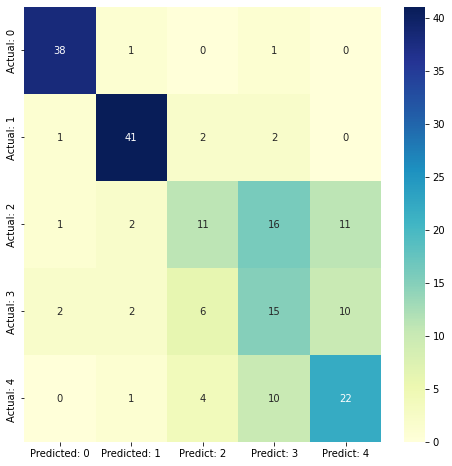

In [43]:
cm = confusion_matrix(y_test, index[1])
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted: 0', 'Predicted: 1', 'Predict: 2', 'Predict: 3', 'Predict: 4'], 
                                    index = ['Actual: 0', 'Actual: 1', 'Actual: 2', 'Actual: 3', 'Actual: 4 '])
plt.figure(figsize = (8, 8))
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = "YlGnBu");

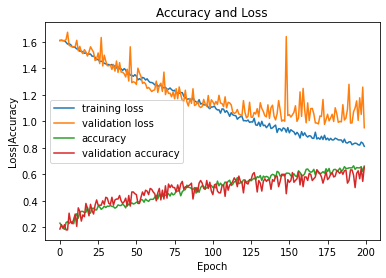

In [44]:
fig = plt.figure()
numOfEpoch = 200
plt.plot(np.arange(0, numOfEpoch), history.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), history.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), history.history['accuracy'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

## Sử dụng KFold để đánh giá mô hình

In [45]:
num_folds = 10
# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

In [46]:
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((Y_train, Y_test), axis=0)

In [47]:
kfold = KFold(n_splits=num_folds, shuffle=True)

In [48]:
fold_no = 1
for train, test in kfold.split(inputs, targets):
    network = models.Sequential()
    network.add(layers.Dense(32, activation='relu', input_shape=(7, )))
    network.add(layers.Dense(64, activation='relu'))
    network.add(layers.Dense(32, activation='relu'))
    network.add(layers.Dense(16, activation='relu'))
    network.add(layers.Dense(8, activation='relu'))
    network.add(layers.Dense(5, activation='softmax'))
#
# Configure the network with optimizer, loss function and accuracy
#
    network.compile(optimizer = "Adam",
                loss='categorical_crossentropy',
                metrics=['accuracy'])
#
    
# Fit the network
#


    history = network.fit(inputs[train], targets[train],
                    epochs = 200,
                    batch_size = 15)
    # Generate generalization metrics
    scores = network.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {network.metrics_names[0]} of {scores[0]}; {network.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

Epoch 1/200
39/39 [==============================] - 1s 4ms/step - loss: 1.6190 - accuracy: 0.2175
Epoch 2/200
39/39 [==============================] - 0s 5ms/step - loss: 1.5258 - accuracy: 0.2997
Epoch 3/200
39/39 [==============================] - 0s 5ms/step - loss: 1.4613 - accuracy: 0.3305
Epoch 4/200
39/39 [==============================] - 0s 4ms/step - loss: 1.4048 - accuracy: 0.3647
Epoch 5/200
39/39 [==============================] - 0s 4ms/step - loss: 1.3559 - accuracy: 0.3716
Epoch 6/200
39/39 [==============================] - 0s 9ms/step - loss: 1.3046 - accuracy: 0.4092
Epoch 7/200
39/39 [==============================] - 0s 5ms/step - loss: 1.2779 - accuracy: 0.4366
Epoch 8/200
39/39 [==============================] - 0s 2ms/step - loss: 1.2281 - accuracy: 0.4418
Epoch 9/200
39/39 [==============================] - 0s 1ms/step - loss: 1.2218 - accuracy: 0.4640
Epoch 10/200
39/39 [==============================] - 0s 5ms/step - loss: 1.1965 - accuracy: 0.4726
Epoch 11/

In [49]:
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.6338420510292053 - Accuracy: 80.0000011920929%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.6812494397163391 - Accuracy: 76.92307829856873%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.744670569896698 - Accuracy: 67.69230961799622%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.6566691994667053 - Accuracy: 73.84615540504456%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.5167496800422668 - Accuracy: 81.53846263885498%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.9016969203948975 - Accuracy: 66.15384817123413%
------------------------------------------------------------------------
>